# Microgrid Optimization Visualizations

This notebook creates comprehensive visualizations for the microgrid optimization model, perfect for slideshow presentations.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pyomo.environ import SolverFactory, value, TerminationCondition
from edited_optimizer import build_model

# Set style for professional-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        plt.rcParams['axes.grid'] = True
        plt.rcParams['grid.alpha'] = 0.3

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

In [4]:
# Build and solve the optimization model
model = build_model()
solver = SolverFactory("cbc")
result = solver.solve(model, tee=False)

# Check if solution is optimal
if result.solver.termination_condition == TerminationCondition.optimal:
    print(f"✓ Optimization successful!")
    print(f"Total cost: ${value(model.Obj):.2f}")
else:
    print(f"⚠ Warning: {result.solver.termination_condition}")

# Extract time series data
hours = list(model.T)
load = [model.L[t] for t in hours]
solar_available = [model.A[t] for t in hours]
grid_price = [model.P[t] for t in hours]

# Extract solution variables
solar_used = [value(model.s[t]) for t in hours]
grid_power = [value(model.g[t]) for t in hours]
generator_power = [value(model.gen[t]) for t in hours]
battery_charge = [value(model.b_ch[t]) for t in hours]
battery_discharge = [value(model.b_dis[t]) for t in hours]
battery_soc = [value(model.SoC[t]) for t in hours]
generator_on = [value(model.gen_on[t]) for t in hours]
startup_events = [value(model.y_start[t]) for t in hours]

# Calculate costs - ensure we extract numeric values from Pyomo parameters
grid_costs = [value(model.P[t]) * value(model.g[t]) for t in hours]
generator_costs = [value(model.G_rate) * value(model.gen[t]) for t in hours]
startup_costs = [value(model.C_start) * value(model.y_start[t]) for t in hours]
battery_costs = [value(model.alpha) * (value(model.b_ch[t]) + value(model.b_dis[t])) for t in hours]

total_grid_cost = sum(grid_costs)
total_generator_cost = sum(generator_costs)
total_startup_cost = sum(startup_costs)
total_battery_cost = sum(battery_costs)
total_cost = value(model.Obj)

print(f"\nCost Breakdown:")
print(f"  Grid: ${total_grid_cost:.2f}")
print(f"  Generator (energy): ${total_generator_cost:.2f}")
print(f"  Generator (startup): ${total_startup_cost:.2f}")
print(f"  Battery degradation: ${total_battery_cost:.2f}")
print(f"  Total: ${total_cost:.2f}")

✓ Optimization successful!
Total cost: $1142.54

Cost Breakdown:
  Grid: $248.52
  Generator (energy): $578.56
  Generator (startup): $300.00
  Battery degradation: $15.46
  Total: $1142.54


## Graph 1: Input Profiles (Load, Solar Availability, Grid Prices)

This shows the three key inputs to the optimization problem.

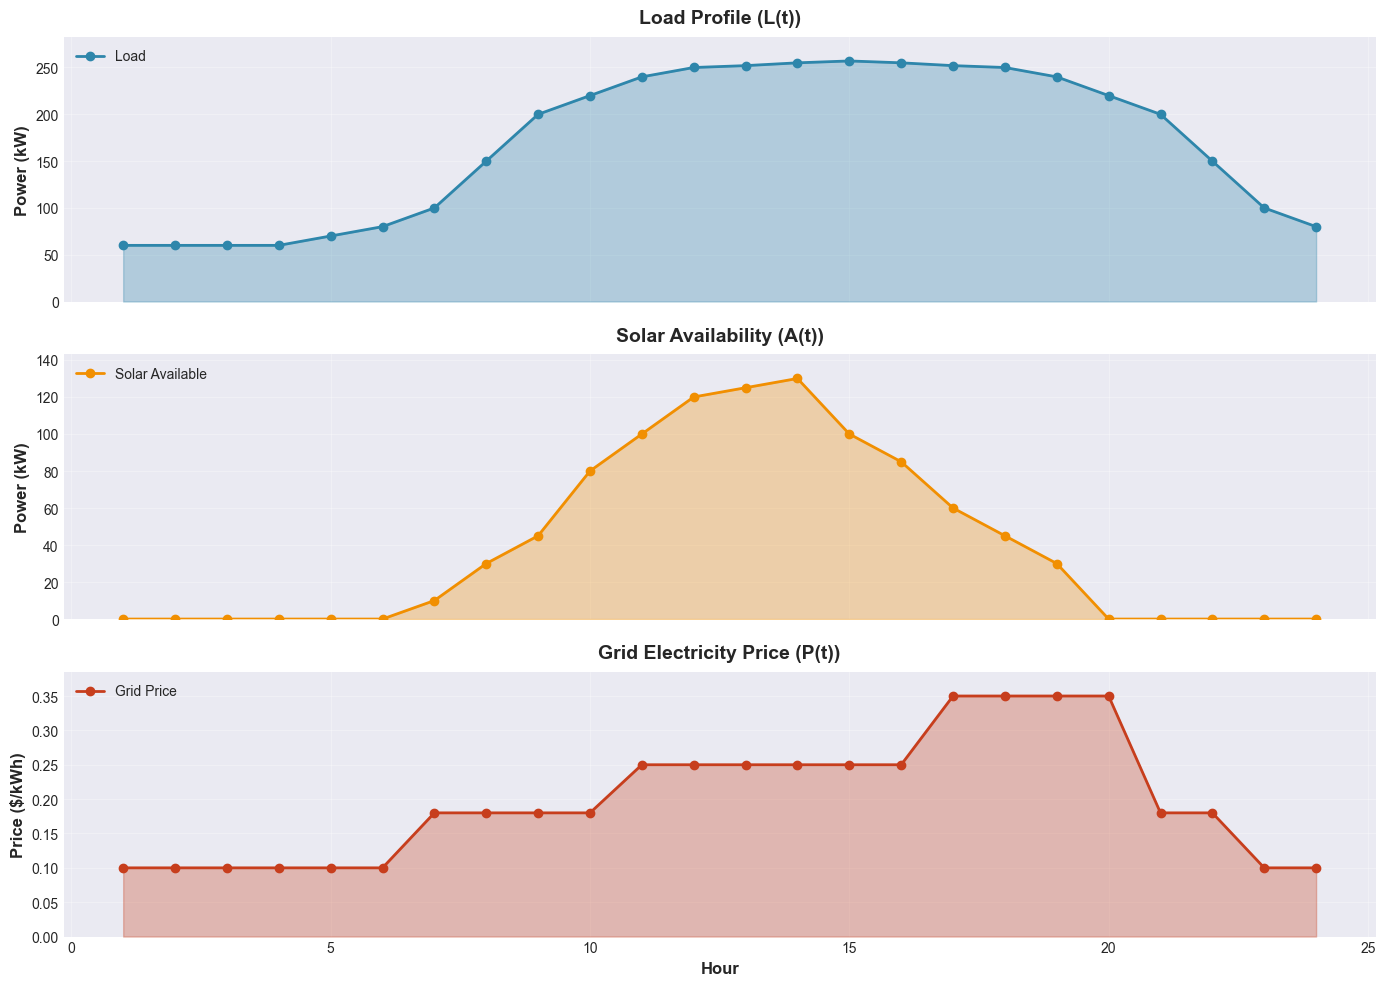

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Load profile
ax1.plot(hours, load, 'o-', linewidth=2, markersize=6, color='#2E86AB', label='Load')
ax1.fill_between(hours, load, alpha=0.3, color='#2E86AB')
ax1.set_ylabel('Power (kW)', fontweight='bold')
ax1.set_title('Load Profile (L(t))', fontweight='bold', pad=10)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_ylim(0, max(load) * 1.1)

# Solar availability
ax2.plot(hours, solar_available, 'o-', linewidth=2, markersize=6, color='#F18F01', label='Solar Available')
ax2.fill_between(hours, solar_available, alpha=0.3, color='#F18F01')
ax2.set_ylabel('Power (kW)', fontweight='bold')
ax2.set_title('Solar Availability (A(t))', fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2.set_ylim(0, max(solar_available) * 1.1 if max(solar_available) > 0 else 10)

# Grid prices
ax3.plot(hours, grid_price, 'o-', linewidth=2, markersize=6, color='#C73E1D', label='Grid Price')
ax3.fill_between(hours, grid_price, alpha=0.3, color='#C73E1D')
ax3.set_xlabel('Hour', fontweight='bold')
ax3.set_ylabel('Price ($/kWh)', fontweight='bold')
ax3.set_title('Grid Electricity Price (P(t))', fontweight='bold', pad=10)
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper left')
ax3.set_ylim(0, max(grid_price) * 1.1)

plt.tight_layout()
plt.savefig('input_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

## Graph 2: Energy Dispatch Over Time

Shows how energy from different sources is dispatched to meet the load.

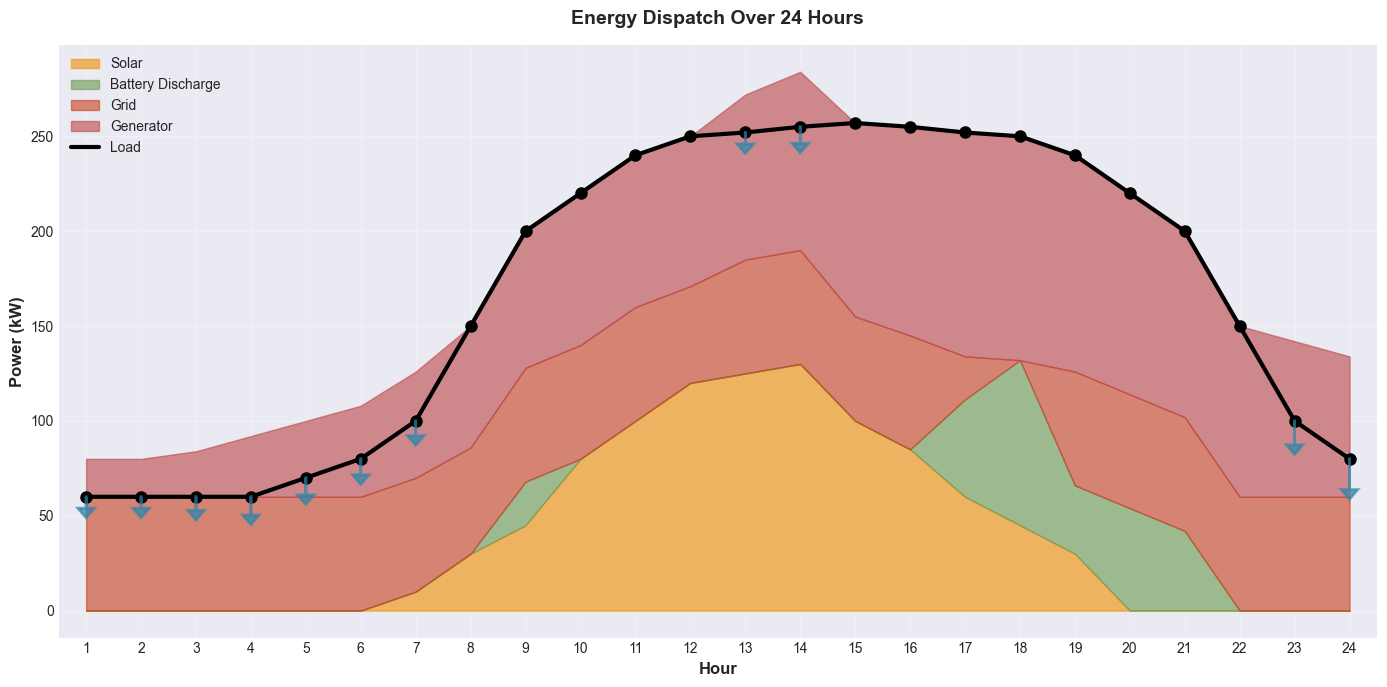

In [6]:
fig, ax = plt.subplots(figsize=(14, 7))

# Stacked area plot showing supply sources
ax.fill_between(hours, 0, solar_used, alpha=0.6, color='#F18F01', label='Solar')
ax.fill_between(hours, solar_used, 
                 [solar_used[i] + battery_discharge[i] for i in range(len(hours))], 
                 alpha=0.6, color='#6A994E', label='Battery Discharge')
ax.fill_between(hours, 
                 [solar_used[i] + battery_discharge[i] for i in range(len(hours))],
                 [solar_used[i] + battery_discharge[i] + grid_power[i] for i in range(len(hours))],
                 alpha=0.6, color='#C73E1D', label='Grid')
ax.fill_between(hours,
                 [solar_used[i] + battery_discharge[i] + grid_power[i] for i in range(len(hours))],
                 [solar_used[i] + battery_discharge[i] + grid_power[i] + generator_power[i] for i in range(len(hours))],
                 alpha=0.6, color='#BC4749', label='Generator')

# Overlay load line
ax.plot(hours, load, 'k-', linewidth=3, label='Load', zorder=10)
ax.plot(hours, load, 'ko', markersize=8, zorder=11)

# Battery charging (negative contribution)
for i, b_ch in enumerate(battery_charge):
    if b_ch > 0.1:  # Only show significant charging
        ax.arrow(i+1, load[i], 0, -b_ch*0.3, head_width=0.3, head_length=5, 
                fc='#2E86AB', ec='#2E86AB', linewidth=2, alpha=0.7, zorder=12)

ax.set_xlabel('Hour', fontweight='bold', fontsize=12)
ax.set_ylabel('Power (kW)', fontweight='bold', fontsize=12)
ax.set_title('Energy Dispatch Over 24 Hours', fontweight='bold', fontsize=14, pad=15)
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0.5, 24.5)
ax.set_xticks(range(1, 25))

plt.tight_layout()
plt.savefig('energy_dispatch.png', dpi=300, bbox_inches='tight')
plt.show()

## Graph 3: Battery State of Charge

Shows how the battery is charged and discharged throughout the day.

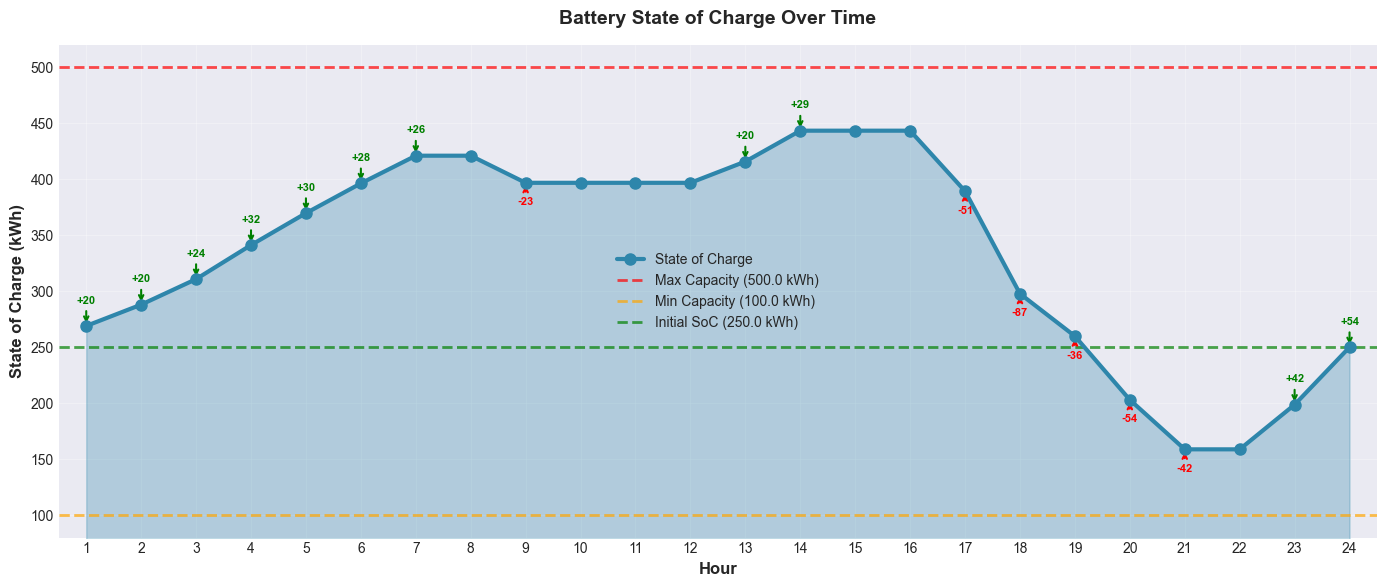

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot SoC
ax.plot(hours, battery_soc, 'o-', linewidth=3, markersize=8, color='#2E86AB', label='State of Charge', zorder=5)
ax.fill_between(hours, battery_soc, alpha=0.3, color='#2E86AB')

# Add battery capacity limits
ax.axhline(y=model.B_max.value, color='r', linestyle='--', linewidth=2, label=f'Max Capacity ({model.B_max.value} kWh)', alpha=0.7)
ax.axhline(y=model.B_min.value, color='orange', linestyle='--', linewidth=2, label=f'Min Capacity ({model.B_min.value} kWh)', alpha=0.7)
ax.axhline(y=model.SoC_initial.value, color='g', linestyle='--', linewidth=2, label=f'Initial SoC ({model.SoC_initial.value} kWh)', alpha=0.7)

# Annotate charge/discharge events
for i, (b_ch, b_dis) in enumerate(zip(battery_charge, battery_discharge)):
    if b_ch > 0.1:
        ax.annotate(f'+{b_ch:.0f}', xy=(i+1, battery_soc[i]), 
                   xytext=(i+1, battery_soc[i]+20), fontsize=8, 
                   ha='center', color='green', fontweight='bold',
                   arrowprops=dict(arrowstyle='->', color='green', lw=1.5))
    if b_dis > 0.1:
        ax.annotate(f'-{b_dis:.0f}', xy=(i+1, battery_soc[i]), 
                   xytext=(i+1, battery_soc[i]-20), fontsize=8, 
                   ha='center', color='red', fontweight='bold',
                   arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

ax.set_xlabel('Hour', fontweight='bold', fontsize=12)
ax.set_ylabel('State of Charge (kWh)', fontweight='bold', fontsize=12)
ax.set_title('Battery State of Charge Over Time', fontweight='bold', fontsize=14, pad=15)
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0.5, 24.5)
ax.set_xticks(range(1, 25))
ax.set_ylim(model.B_min.value - 20, model.B_max.value + 20)

plt.tight_layout()
plt.savefig('battery_soc.png', dpi=300, bbox_inches='tight')
plt.show()

## Graph 4: Generator Operation Schedule

Shows when the generator is on/off and its power output.

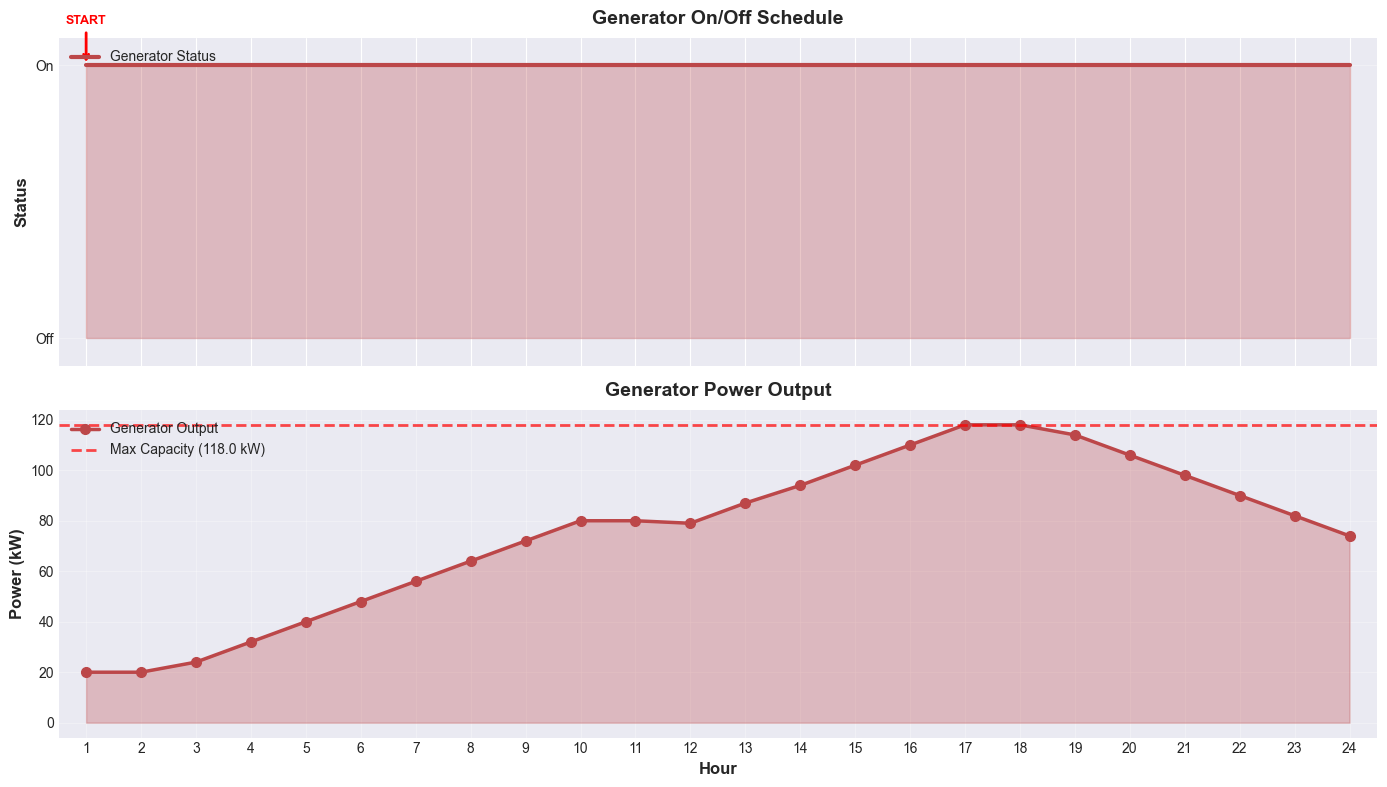

Generator startup events: 1 times
Startup hours: [1]
Total startup cost: $300.00


In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Generator on/off status
ax1.step(hours, generator_on, where='post', linewidth=3, color='#BC4749', label='Generator Status')
ax1.fill_between(hours, generator_on, step='post', alpha=0.3, color='#BC4749')
ax1.set_ylabel('Status', fontweight='bold', fontsize=12)
ax1.set_title('Generator On/Off Schedule', fontweight='bold', fontsize=14, pad=10)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Off', 'On'])
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(-0.1, 1.1)
ax1.legend(loc='upper left')

# Mark startup events
startup_hours = [h for h, s in zip(hours, startup_events) if s > 0.5]
for h in startup_hours:
    ax1.annotate('START', xy=(h, 1), xytext=(h, 1.15), 
                ha='center', fontsize=9, fontweight='bold', color='red',
                arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Generator power output
ax2.plot(hours, generator_power, 'o-', linewidth=2.5, markersize=7, color='#BC4749', label='Generator Output')
ax2.fill_between(hours, generator_power, alpha=0.3, color='#BC4749')
ax2.axhline(y=model.C_gen.value, color='r', linestyle='--', linewidth=2, 
           label=f'Max Capacity ({model.C_gen.value} kW)', alpha=0.7)
ax2.set_xlabel('Hour', fontweight='bold', fontsize=12)
ax2.set_ylabel('Power (kW)', fontweight='bold', fontsize=12)
ax2.set_title('Generator Power Output', fontweight='bold', fontsize=14, pad=10)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.5, 24.5)
ax2.set_xticks(range(1, 25))

plt.tight_layout()
plt.savefig('generator_schedule.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Generator startup events: {len(startup_hours)} times")
print(f"Startup hours: {startup_hours}")
print(f"Total startup cost: ${sum(startup_costs):.2f}")

## Graph 5: Cost Breakdown

Visualizes the different cost components.

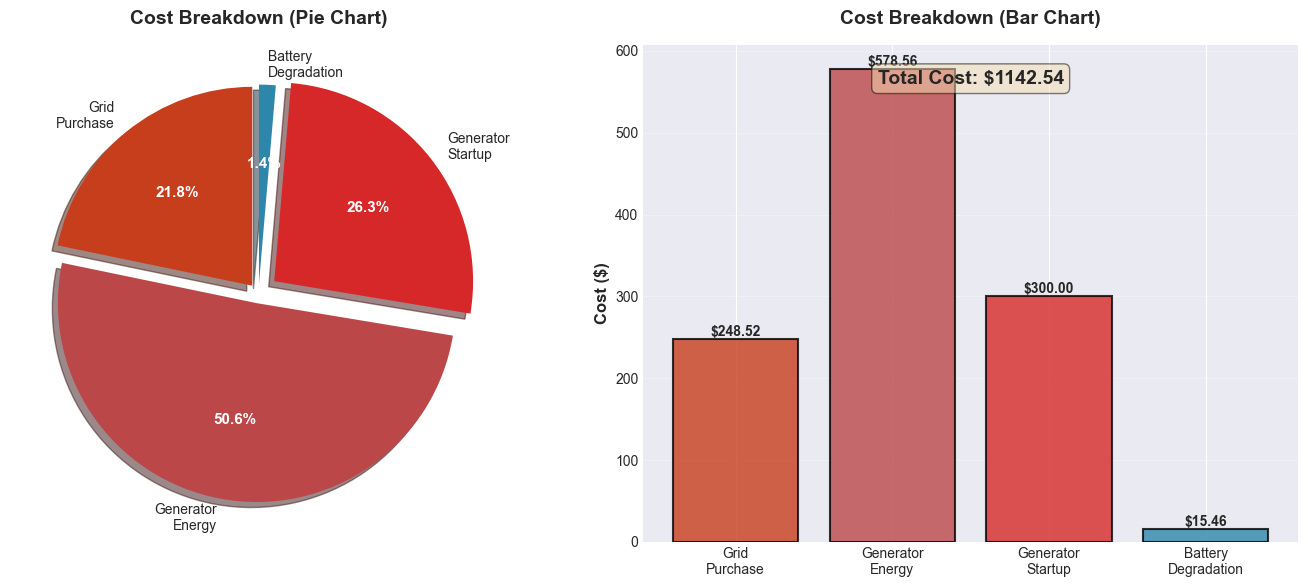

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
costs = [total_grid_cost, total_generator_cost, total_startup_cost, total_battery_cost]
labels = ['Grid\nPurchase', 'Generator\nEnergy', 'Generator\nStartup', 'Battery\nDegradation']
colors = ['#C73E1D', '#BC4749', '#D62828', '#2E86AB']
explode = (0.05, 0.05, 0.1, 0.05)  # Slightly separate slices

wedges, texts, autotexts = ax1.pie(costs, labels=labels, colors=colors, autopct='%1.1f%%',
                                    startangle=90, explode=explode, shadow=True)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

ax1.set_title('Cost Breakdown (Pie Chart)', fontweight='bold', fontsize=14, pad=15)

# Bar chart
bars = ax2.bar(labels, costs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Cost ($)', fontweight='bold', fontsize=12)
ax2.set_title('Cost Breakdown (Bar Chart)', fontweight='bold', fontsize=14, pad=15)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, cost in zip(bars, costs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${cost:.2f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add total cost text
ax2.text(0.5, 0.95, f'Total Cost: ${total_cost:.2f}', 
        transform=ax2.transAxes, fontsize=14, fontweight='bold',
        ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('cost_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

## Graph 6: Hourly Cost Analysis

Shows how costs vary throughout the day.

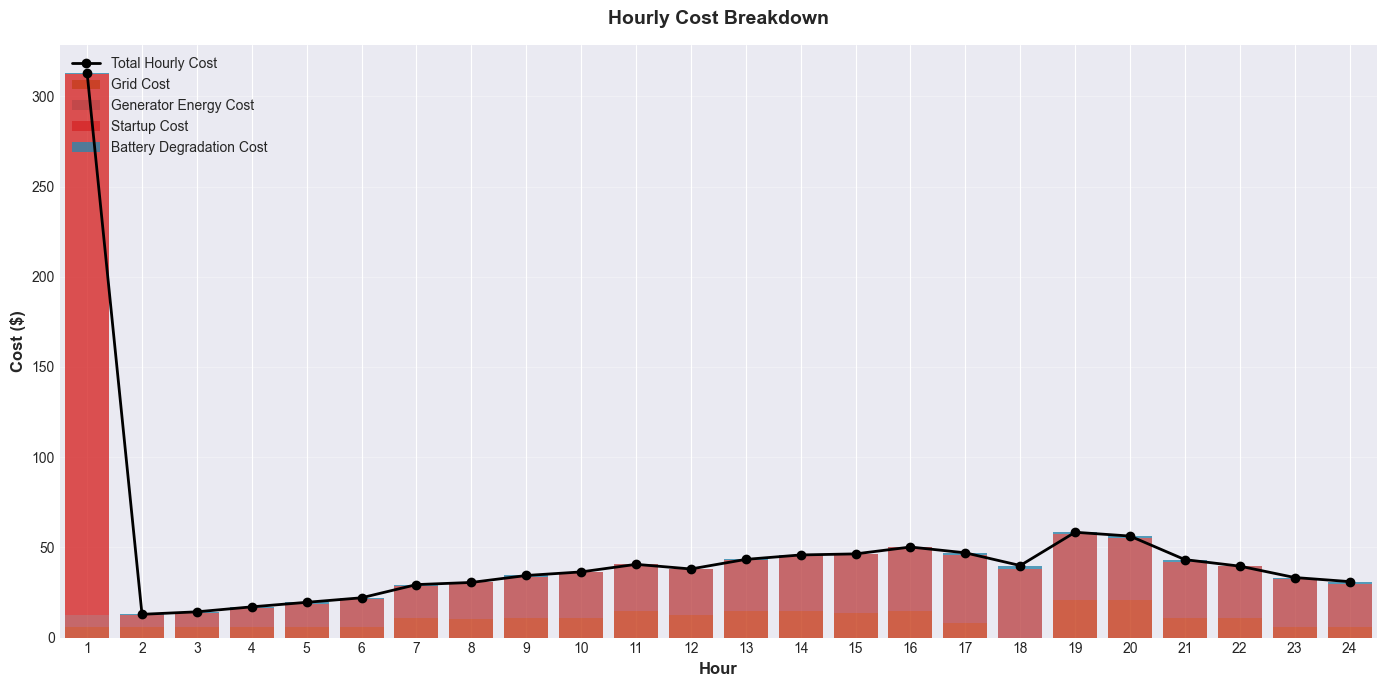

In [10]:
fig, ax = plt.subplots(figsize=(14, 7))

# Stacked bar chart for hourly costs
hourly_total_costs = [g + gen + st + b for g, gen, st, b in 
                      zip(grid_costs, generator_costs, startup_costs, battery_costs)]

ax.bar(hours, grid_costs, label='Grid Cost', color='#C73E1D', alpha=0.8)
ax.bar(hours, generator_costs, bottom=grid_costs, label='Generator Energy Cost', color='#BC4749', alpha=0.8)
ax.bar(hours, startup_costs, 
       bottom=[g + gen for g, gen in zip(grid_costs, generator_costs)], 
       label='Startup Cost', color='#D62828', alpha=0.8)
ax.bar(hours, battery_costs,
       bottom=[g + gen + st for g, gen, st in zip(grid_costs, generator_costs, startup_costs)],
       label='Battery Degradation Cost', color='#2E86AB', alpha=0.8)

# Overlay total cost line
ax.plot(hours, hourly_total_costs, 'ko-', linewidth=2, markersize=6, label='Total Hourly Cost', zorder=10)

ax.set_xlabel('Hour', fontweight='bold', fontsize=12)
ax.set_ylabel('Cost ($)', fontweight='bold', fontsize=12)
ax.set_title('Hourly Cost Breakdown', fontweight='bold', fontsize=14, pad=15)
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xlim(0.5, 24.5)
ax.set_xticks(range(1, 25))

plt.tight_layout()
plt.savefig('hourly_costs.png', dpi=300, bbox_inches='tight')
plt.show()

## Graph 7: Price vs Grid Usage Correlation

Shows how the optimizer responds to price signals by adjusting grid purchases.

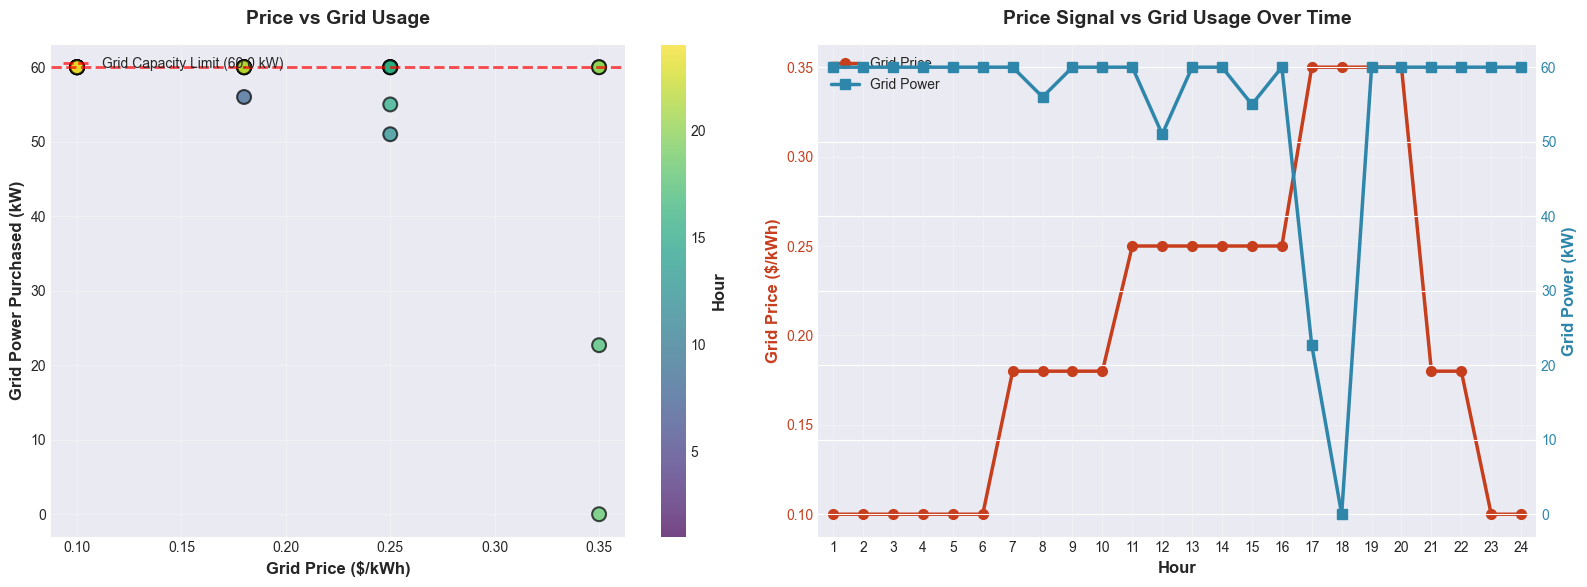

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Price vs Grid Usage
scatter = ax1.scatter(grid_price, grid_power, c=hours, cmap='viridis', 
                     s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax1.set_xlabel('Grid Price ($/kWh)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Grid Power Purchased (kW)', fontweight='bold', fontsize=12)
ax1.set_title('Price vs Grid Usage', fontweight='bold', fontsize=14, pad=15)
ax1.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Hour', fontweight='bold')

# Add grid capacity line
ax1.axhline(y=model.Grid_cap.value, color='r', linestyle='--', linewidth=2, 
           label=f'Grid Capacity Limit ({model.Grid_cap.value} kW)', alpha=0.7)
ax1.legend(loc='upper left')

# Overlay plot: Price and Grid Usage over time
ax2_twin = ax2.twinx()
line1 = ax2.plot(hours, grid_price, 'o-', linewidth=2.5, markersize=7, 
                color='#C73E1D', label='Grid Price', zorder=5)
line2 = ax2_twin.plot(hours, grid_power, 's-', linewidth=2.5, markersize=7, 
                     color='#2E86AB', label='Grid Power', zorder=5)

ax2.set_xlabel('Hour', fontweight='bold', fontsize=12)
ax2.set_ylabel('Grid Price ($/kWh)', fontweight='bold', fontsize=12, color='#C73E1D')
ax2_twin.set_ylabel('Grid Power (kW)', fontweight='bold', fontsize=12, color='#2E86AB')
ax2.set_title('Price Signal vs Grid Usage Over Time', fontweight='bold', fontsize=14, pad=15)

# Color the y-axis labels
ax2.tick_params(axis='y', labelcolor='#C73E1D')
ax2_twin.tick_params(axis='y', labelcolor='#2E86AB')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', framealpha=0.9)

ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.5, 24.5)
ax2.set_xticks(range(1, 25))

plt.tight_layout()
plt.savefig('price_vs_usage.png', dpi=300, bbox_inches='tight')
plt.show()

## Graph 8: Energy Balance Visualization

Shows supply vs demand balance at each hour.

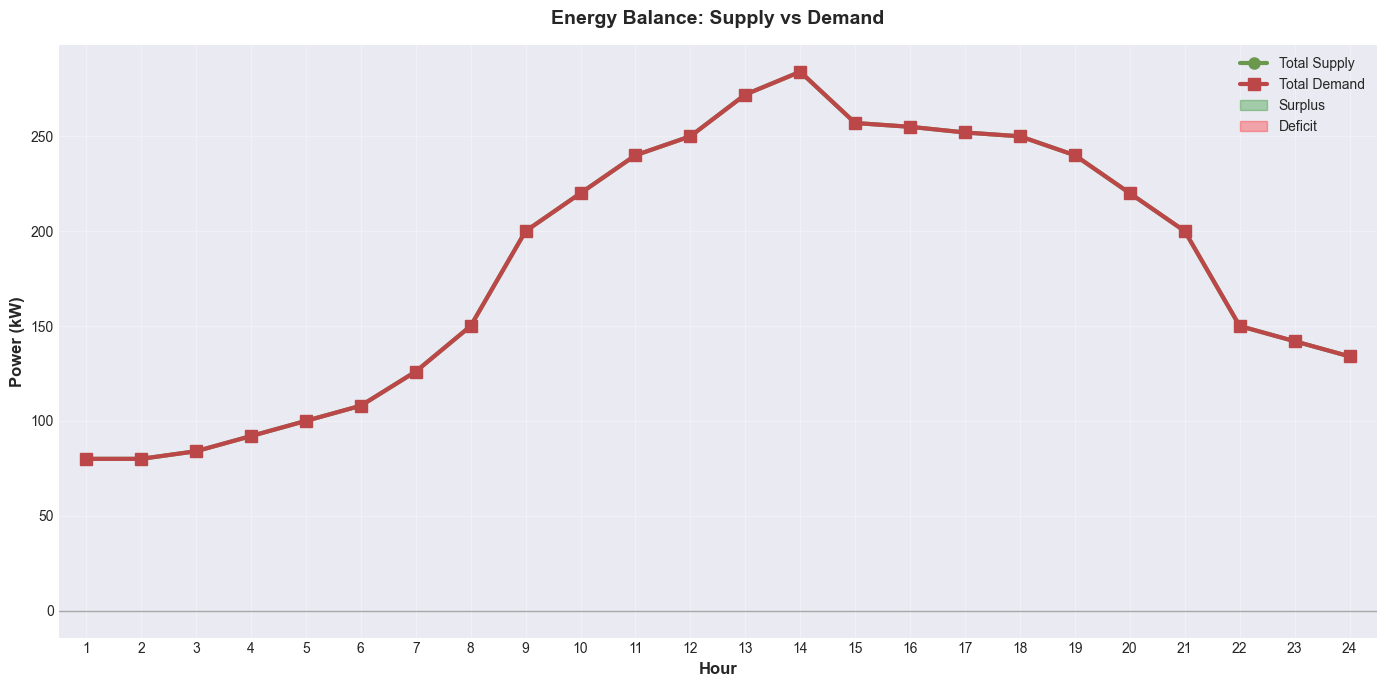

Energy balance check:
✓ All hours balanced!


In [12]:
# Calculate supply and demand
supply = [s + b_dis + g + gen for s, b_dis, g, gen in 
          zip(solar_used, battery_discharge, grid_power, generator_power)]
demand = [l + b_ch for l, b_ch in zip(load, battery_charge)]

fig, ax = plt.subplots(figsize=(14, 7))

# Plot supply and demand
ax.plot(hours, supply, 'o-', linewidth=3, markersize=8, color='#6A994E', label='Total Supply', zorder=5)
ax.plot(hours, demand, 's-', linewidth=3, markersize=8, color='#BC4749', label='Total Demand', zorder=5)

# Fill area between to show balance
ax.fill_between(hours, supply, demand, where=[s >= d for s, d in zip(supply, demand)], 
                alpha=0.3, color='green', label='Surplus')
ax.fill_between(hours, supply, demand, where=[s < d for s, d in zip(supply, demand)], 
                alpha=0.3, color='red', label='Deficit')

# Add perfect balance line
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)

# Annotate balance
for i, (s, d) in enumerate(zip(supply, demand)):
    if abs(s - d) > 0.1:  # Only annotate if there's a significant difference
        diff = s - d
        ax.annotate(f'{diff:+.1f}', xy=(i+1, (s+d)/2), 
                   fontsize=7, ha='center', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_xlabel('Hour', fontweight='bold', fontsize=12)
ax.set_ylabel('Power (kW)', fontweight='bold', fontsize=12)
ax.set_title('Energy Balance: Supply vs Demand', fontweight='bold', fontsize=14, pad=15)
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0.5, 24.5)
ax.set_xticks(range(1, 25))

plt.tight_layout()
plt.savefig('energy_balance.png', dpi=300, bbox_inches='tight')
plt.show()

# Verify balance
print("Energy balance check:")
for i, (s, d) in enumerate(zip(supply, demand)):
    if abs(s - d) > 0.01:
        print(f"  Hour {i+1}: Supply={s:.2f} kW, Demand={d:.2f} kW, Diff={s-d:.2f} kW")
print("✓ All hours balanced!" if all(abs(s-d) < 0.01 for s, d in zip(supply, demand)) else "")

## Graph 9: Summary Dashboard

A comprehensive overview combining key metrics in one view.

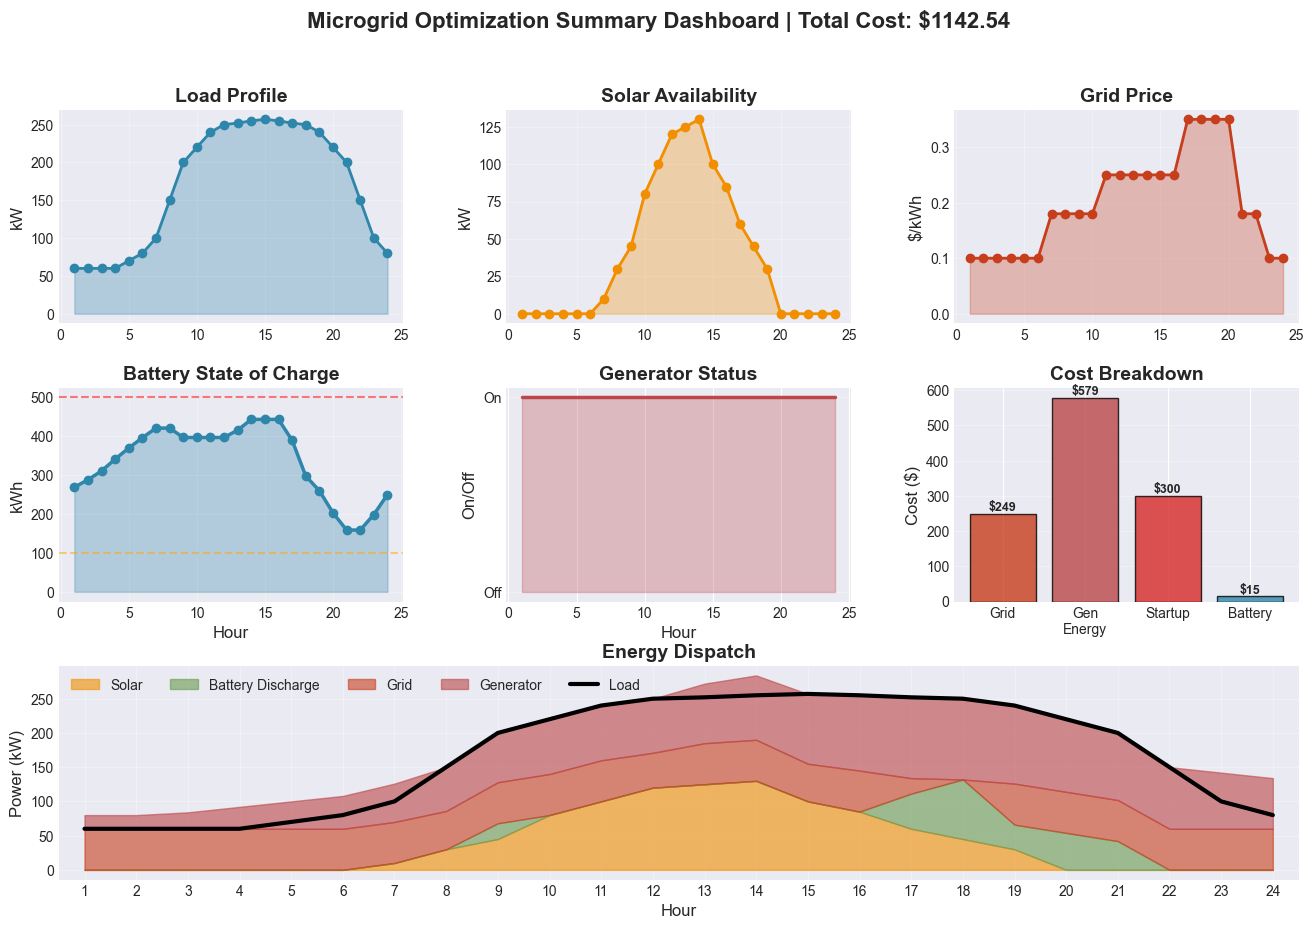

In [13]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Top row: Input profiles
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(hours, load, 'o-', linewidth=2, color='#2E86AB')
ax1.fill_between(hours, load, alpha=0.3, color='#2E86AB')
ax1.set_title('Load Profile', fontweight='bold')
ax1.set_ylabel('kW')
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(hours, solar_available, 'o-', linewidth=2, color='#F18F01')
ax2.fill_between(hours, solar_available, alpha=0.3, color='#F18F01')
ax2.set_title('Solar Availability', fontweight='bold')
ax2.set_ylabel('kW')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(hours, grid_price, 'o-', linewidth=2, color='#C73E1D')
ax3.fill_between(hours, grid_price, alpha=0.3, color='#C73E1D')
ax3.set_title('Grid Price', fontweight='bold')
ax3.set_ylabel('$/kWh')
ax3.grid(True, alpha=0.3)

# Middle row: Key outputs
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(hours, battery_soc, 'o-', linewidth=2.5, color='#2E86AB')
ax4.fill_between(hours, battery_soc, alpha=0.3, color='#2E86AB')
ax4.axhline(y=model.B_max.value, color='r', linestyle='--', alpha=0.5)
ax4.axhline(y=model.B_min.value, color='orange', linestyle='--', alpha=0.5)
ax4.set_title('Battery State of Charge', fontweight='bold')
ax4.set_ylabel('kWh')
ax4.set_xlabel('Hour')
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.step(hours, generator_on, where='post', linewidth=2.5, color='#BC4749')
ax5.fill_between(hours, generator_on, step='post', alpha=0.3, color='#BC4749')
ax5.set_title('Generator Status', fontweight='bold')
ax5.set_ylabel('On/Off')
ax5.set_xlabel('Hour')
ax5.set_yticks([0, 1])
ax5.set_yticklabels(['Off', 'On'])
ax5.grid(True, alpha=0.3, axis='y')

ax6 = fig.add_subplot(gs[1, 2])
colors_dash = ['#C73E1D', '#BC4749', '#D62828', '#2E86AB']
bars = ax6.bar(['Grid', 'Gen\nEnergy', 'Startup', 'Battery'], 
               [total_grid_cost, total_generator_cost, total_startup_cost, total_battery_cost],
               color=colors_dash, alpha=0.8, edgecolor='black')
ax6.set_title('Cost Breakdown', fontweight='bold')
ax6.set_ylabel('Cost ($)')
ax6.grid(True, alpha=0.3, axis='y')
for bar, cost in zip(bars, [total_grid_cost, total_generator_cost, total_startup_cost, total_battery_cost]):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'${cost:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Bottom row: Energy flows
ax7 = fig.add_subplot(gs[2, :])
ax7.fill_between(hours, 0, solar_used, alpha=0.6, color='#F18F01', label='Solar')
ax7.fill_between(hours, solar_used, 
                 [solar_used[i] + battery_discharge[i] for i in range(len(hours))], 
                 alpha=0.6, color='#6A994E', label='Battery Discharge')
ax7.fill_between(hours, 
                 [solar_used[i] + battery_discharge[i] for i in range(len(hours))],
                 [solar_used[i] + battery_discharge[i] + grid_power[i] for i in range(len(hours))],
                 alpha=0.6, color='#C73E1D', label='Grid')
ax7.fill_between(hours,
                 [solar_used[i] + battery_discharge[i] + grid_power[i] for i in range(len(hours))],
                 [solar_used[i] + battery_discharge[i] + grid_power[i] + generator_power[i] for i in range(len(hours))],
                 alpha=0.6, color='#BC4749', label='Generator')
ax7.plot(hours, load, 'k-', linewidth=3, label='Load', zorder=10)
ax7.set_title('Energy Dispatch', fontweight='bold')
ax7.set_xlabel('Hour')
ax7.set_ylabel('Power (kW)')
ax7.legend(loc='upper left', ncol=5)
ax7.grid(True, alpha=0.3)
ax7.set_xlim(0.5, 24.5)
ax7.set_xticks(range(1, 25))

# Add title
fig.suptitle(f'Microgrid Optimization Summary Dashboard | Total Cost: ${total_cost:.2f}', 
             fontsize=16, fontweight='bold', y=0.98)

plt.savefig('summary_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary Statistics

Key metrics from the optimization run.

In [14]:
print("="*60)
print("MICROGRID OPTIMIZATION SUMMARY")
print("="*60)
print(f"\nTotal Cost: ${total_cost:.2f}")
print(f"\nCost Breakdown:")
print(f"  Grid Purchase:        ${total_grid_cost:8.2f} ({total_grid_cost/total_cost*100:.1f}%)")
print(f"  Generator Energy:     ${total_generator_cost:8.2f} ({total_generator_cost/total_cost*100:.1f}%)")
print(f"  Generator Startup:    ${total_startup_cost:8.2f} ({total_startup_cost/total_cost*100:.1f}%)")
print(f"  Battery Degradation:  ${total_battery_cost:8.2f} ({total_battery_cost/total_cost*100:.1f}%)")

print(f"\nEnergy Statistics:")
print(f"  Total Load:           {sum(load):8.1f} kWh")
print(f"  Solar Used:           {sum(solar_used):8.1f} kWh ({sum(solar_used)/sum(load)*100:.1f}% of load)")
print(f"  Grid Purchased:       {sum(grid_power):8.1f} kWh ({sum(grid_power)/sum(load)*100:.1f}% of load)")
print(f"  Generator Output:     {sum(generator_power):8.1f} kWh ({sum(generator_power)/sum(load)*100:.1f}% of load)")
print(f"  Battery Charged:      {sum(battery_charge):8.1f} kWh")
print(f"  Battery Discharged:   {sum(battery_discharge):8.1f} kWh")

print(f"\nBattery Statistics:")
print(f"  Initial SoC:          {battery_soc[0]:8.1f} kWh")
print(f"  Final SoC:            {battery_soc[-1]:8.1f} kWh")
print(f"  Min SoC:              {min(battery_soc):8.1f} kWh")
print(f"  Max SoC:              {max(battery_soc):8.1f} kWh")
print(f"  SoC Range Used:       {max(battery_soc) - min(battery_soc):8.1f} kWh")

print(f"\nGenerator Statistics:")
print(f"  Generator On Hours:   {sum(generator_on):.0f} / 24")
print(f"  Startup Events:       {sum(startup_events):.0f}")
print(f"  Max Output:           {max(generator_power):8.1f} kW")
print(f"  Avg Output (when on): {sum(generator_power)/max(sum(generator_on), 1):8.1f} kW")

print(f"\nGrid Statistics:")
print(f"  Max Grid Purchase:    {max(grid_power):8.1f} kW")
print(f"  Grid Capacity Limit:  {model.Grid_cap.value:8.1f} kW")
print(f"  Capacity Utilization: {max(grid_power)/model.Grid_cap.value*100:.1f}%")
print("="*60)

MICROGRID OPTIMIZATION SUMMARY

Total Cost: $1142.54

Cost Breakdown:
  Grid Purchase:        $  248.52 (21.8%)
  Generator Energy:     $  578.56 (50.6%)
  Generator Startup:    $  300.00 (26.3%)
  Battery Degradation:  $   15.46 (1.4%)

Energy Statistics:
  Total Load:             4061.0 kWh
  Solar Used:              960.0 kWh (23.6% of load)
  Grid Purchased:         1324.7 kWh (32.6% of load)
  Generator Output:       1808.0 kWh (44.5% of load)
  Battery Charged:         325.0 kWh
  Battery Discharged:      293.3 kWh

Battery Statistics:
  Initial SoC:             269.0 kWh
  Final SoC:               250.0 kWh
  Min SoC:                 158.8 kWh
  Max SoC:                 443.3 kWh
  SoC Range Used:          284.5 kWh

Generator Statistics:
  Generator On Hours:   24 / 24
  Startup Events:       1
  Max Output:              118.0 kW
  Avg Output (when on):     75.3 kW

Grid Statistics:
  Max Grid Purchase:        60.0 kW
  Grid Capacity Limit:      60.0 kW
  Capacity Utilization: 